In [1]:
import numpy as np
import skimage
import imageio
import matplotlib.pyplot as plt

from scipy.signal import fftconvolve

In [58]:
def extend(size, img):
    new_img = np.array([np.zeros(img.shape[1] + 2 * size) for i in range(0, img.shape[0] + 2 * size)])
    new_img[size:img.shape[0] + size,  size:img.shape[1] + size] = img.copy()
    for i in range(0, size):
        for j in range(0, img.shape[0]):
            new_img[j + size][i] = new_img[j+ size][size]
            new_img[j + size][i + size + img.shape[1]] = new_img[j + size][size + img.shape[1] - 1]
    for i in range(0, size):
        for j in range(0, new_img.shape[1]):
            new_img[i][j] = new_img[size][j]
            new_img[size + img.shape[0] + i][j] = new_img[size + img.shape[0] - 1][j]
    return new_img


def gradient(sigma, img):
    treshold = int(3 * sigma)
    gray_img = extend(treshold, img)
    gaussian_x = np.array([[(treshold - j) * np.exp((-(i - treshold) ** 2 - (j - treshold) ** 2) / (2 * sigma * sigma)) / (2 * np.power(sigma, 4)) for j in range (0, 2 * treshold + 1)] for i in range(0, 2 * treshold + 1)])
    gaussian_y = np.array([[-(treshold - i) * np.exp((-(i - treshold) ** 2 - (j - treshold) ** 2) / (2 * sigma * sigma)) / (2 * np.power(sigma, 4)) for j in range (0, 2 * treshold + 1)] for i in range(0, 2 * treshold + 1)])
    deriv_x = np.zeros((img.shape[0], img.shape[1]), dtype = float)
    deriv_y = np.zeros((img.shape[0], img.shape[1]), dtype = float)
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            deriv_x[i][j] = np.sum(gray_img[i: i + 2 * treshold + 1, j: j + 2 * treshold + 1] * gaussian_x)
            deriv_y[i][j] = np.sum(gray_img[i: i + 2 * treshold + 1, j: j + 2 * treshold + 1] * gaussian_y)
    return deriv_x, deriv_y


def hysteresis (img1, img2):
    current = img1.copy().astype(np.uint8)
    prev = np.zeros((img1.shape[0], img1.shape[1]), dtype = np.uint8)
    while ((prev != current).any()):
        prev = current.copy()
        for i in range(1, prev.shape[0] - 1):
            for j in range(1, prev.shape[1] - 1):
                if img2[i][j] > 0 and (np.sum(current[i - 2: i + 2, j - 2:j + 2]) > 0):
                    current[i][j] = 255
    return current

def angleMatrixFromGradient(img_x, img_y):
    angleMatrix = np.zeros((img_x.shape[0], img_y.shape[1]), dtype = float)
    for i in range(0, img_x.shape[0]):
        for j in range(0, img_y.shape[1]):
            if img_x[i][j] > 0.1:
                angleMatrix[i][j] = np.degrees(np.arctan(img_y[i][j]/img_x[i][j]))
            elif img_x[i][j] < -0.1 and img_y[i][j] > 0:
                angleMatrix[i][j] = np.degrees(np.arctan(img_y[i][j]/img_x[i][j])) + 180.
            elif img_x[i][j] < -0.1 and img_y[i][j] < 0:
                angleMatrix[i][j] = np.degrees(np.arctan(img_y[i][j]/img_x[i][j])) - 180.
            else:
                angleMatrix[i][j] = 90.
                if img_y[i][j] < 0:
                    angleMatrix[i][j] *= -1
    return angleMatrix

def dir_of_gradient (grad_x, grad_y):
    angleMatrix = angleMatrixFromGradient(grad_x, grad_y)
    for i in range(0, angleMatrix.shape[0]):
        for j in range(0, angleMatrix.shape[1]):
            angle = angleMatrix[i][j]
            if abs(grad_x[i][j]) <= 5 and abs(grad_y[i][j]) <= 5:
                angleMatrix[i][j] = 0
            elif (angle > -22.5 and angle < 22.5) or angle > 157.5 or angle < -157.5:
                angleMatrix[i][j] = 64
            elif (angle > 22.5 and angle < 67.5) or (angle < -112.5 and angle > -157.5):
                angleMatrix[i][j] = 192
            elif (angle > 67.5 and angle < 112.5) or (angle < -67.5 and angle > -112.5):
                angleMatrix[i][j] = 128
            elif (angle > 112.5 and angle < 157.5) or (angle < -22.5 and angle > -67.5):
                angleMatrix[i][j] = 255
    return angleMatrix

def non_max_supressing(sigma, img):
    img_x, img_y = gradient(sigma, img)
    gradientMagnitude = np.sqrt(np.power(img_y, 2) + np.power(img_x, 2))
    img_x *= 255 / np.max(gradientMagnitude)
    img_y *= 255 / np.max(gradientMagnitude)
    gradientMagnitude *= 255 / np.max(gradientMagnitude)
    angleMatrix = angleMatrixFromGradient(img_x, img_y)
    dir_matrix = dir_of_gradient(img_x, img_y)
    res = np.zeros((gradientMagnitude.shape[0], gradientMagnitude.shape[1]), dtype = float)
    for i in range(1, gradientMagnitude.shape[0] - 1):
        for j in range(1, gradientMagnitude.shape[1] - 1):
            p = 0
            q = 0
            angle = angleMatrix[i][j]
            if angle < 0:
                angle += 360
            if (angle >= 0 and angle < 22.5) or (angle >= 157.5 and angle < 202.5) or (angle >= 337.5 and angle < 360):
                p = gradientMagnitude[i][j + 1]
                q = gradientMagnitude[i][j - 1]
            elif (angle >= 22.5 and angle < 67.5) or (angle >= 202.5 and angle < 247.5):
                p = gradientMagnitude[i - 1][j + 1]
                q = gradientMagnitude[i + 1][j - 1]
            elif (angle >= 67.5 and angle < 112.5) or (angle >= 247.5 and angle < 292.5):
                p = gradientMagnitude[i - 1][j]
                q = gradientMagnitude[i + 1][j]
            elif (angle >= 112.5 and angle < 157.5) or (angle >= 292.5 and angle < 337.5):
                p = gradientMagnitude[i - 1][j - 1]
                q = gradientMagnitude[i + 1][j + 1]
            if (gradientMagnitude[i][j] >= p and gradientMagnitude[i][j] >= q):
                res[i][j] = gradientMagnitude[i][j]
            else:
                res[i][j] = 0
    return res
                
def canny (sigma, treshold_min, treshold_max, img):
    non_max_magnitude = non_max_supressing(sigma, img)
    non_max_magnitude1 = non_max_magnitude.copy()
    non_max_magnitude2 = non_max_magnitude.copy()
    for i in range(0, non_max_magnitude.shape[0]):
        for j in range(0, non_max_magnitude.shape[1]):
            if non_max_magnitude[i][j] < treshold_max * 255:
                non_max_magnitude2[i][j] = 0
                if non_max_magnitude[i][j] < treshold_min * 255:
                    non_max_magnitude1[i][j] = 0
    return hysteresis(non_max_magnitude2, non_max_magnitude1)

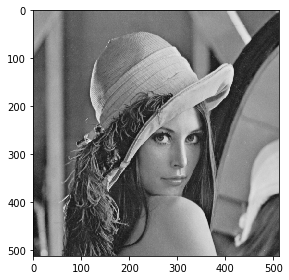

In [55]:
lena = skimage.color.rgb2gray(skimage.io.imread("lena.bmp"))
skimage.io.imshow(lena)

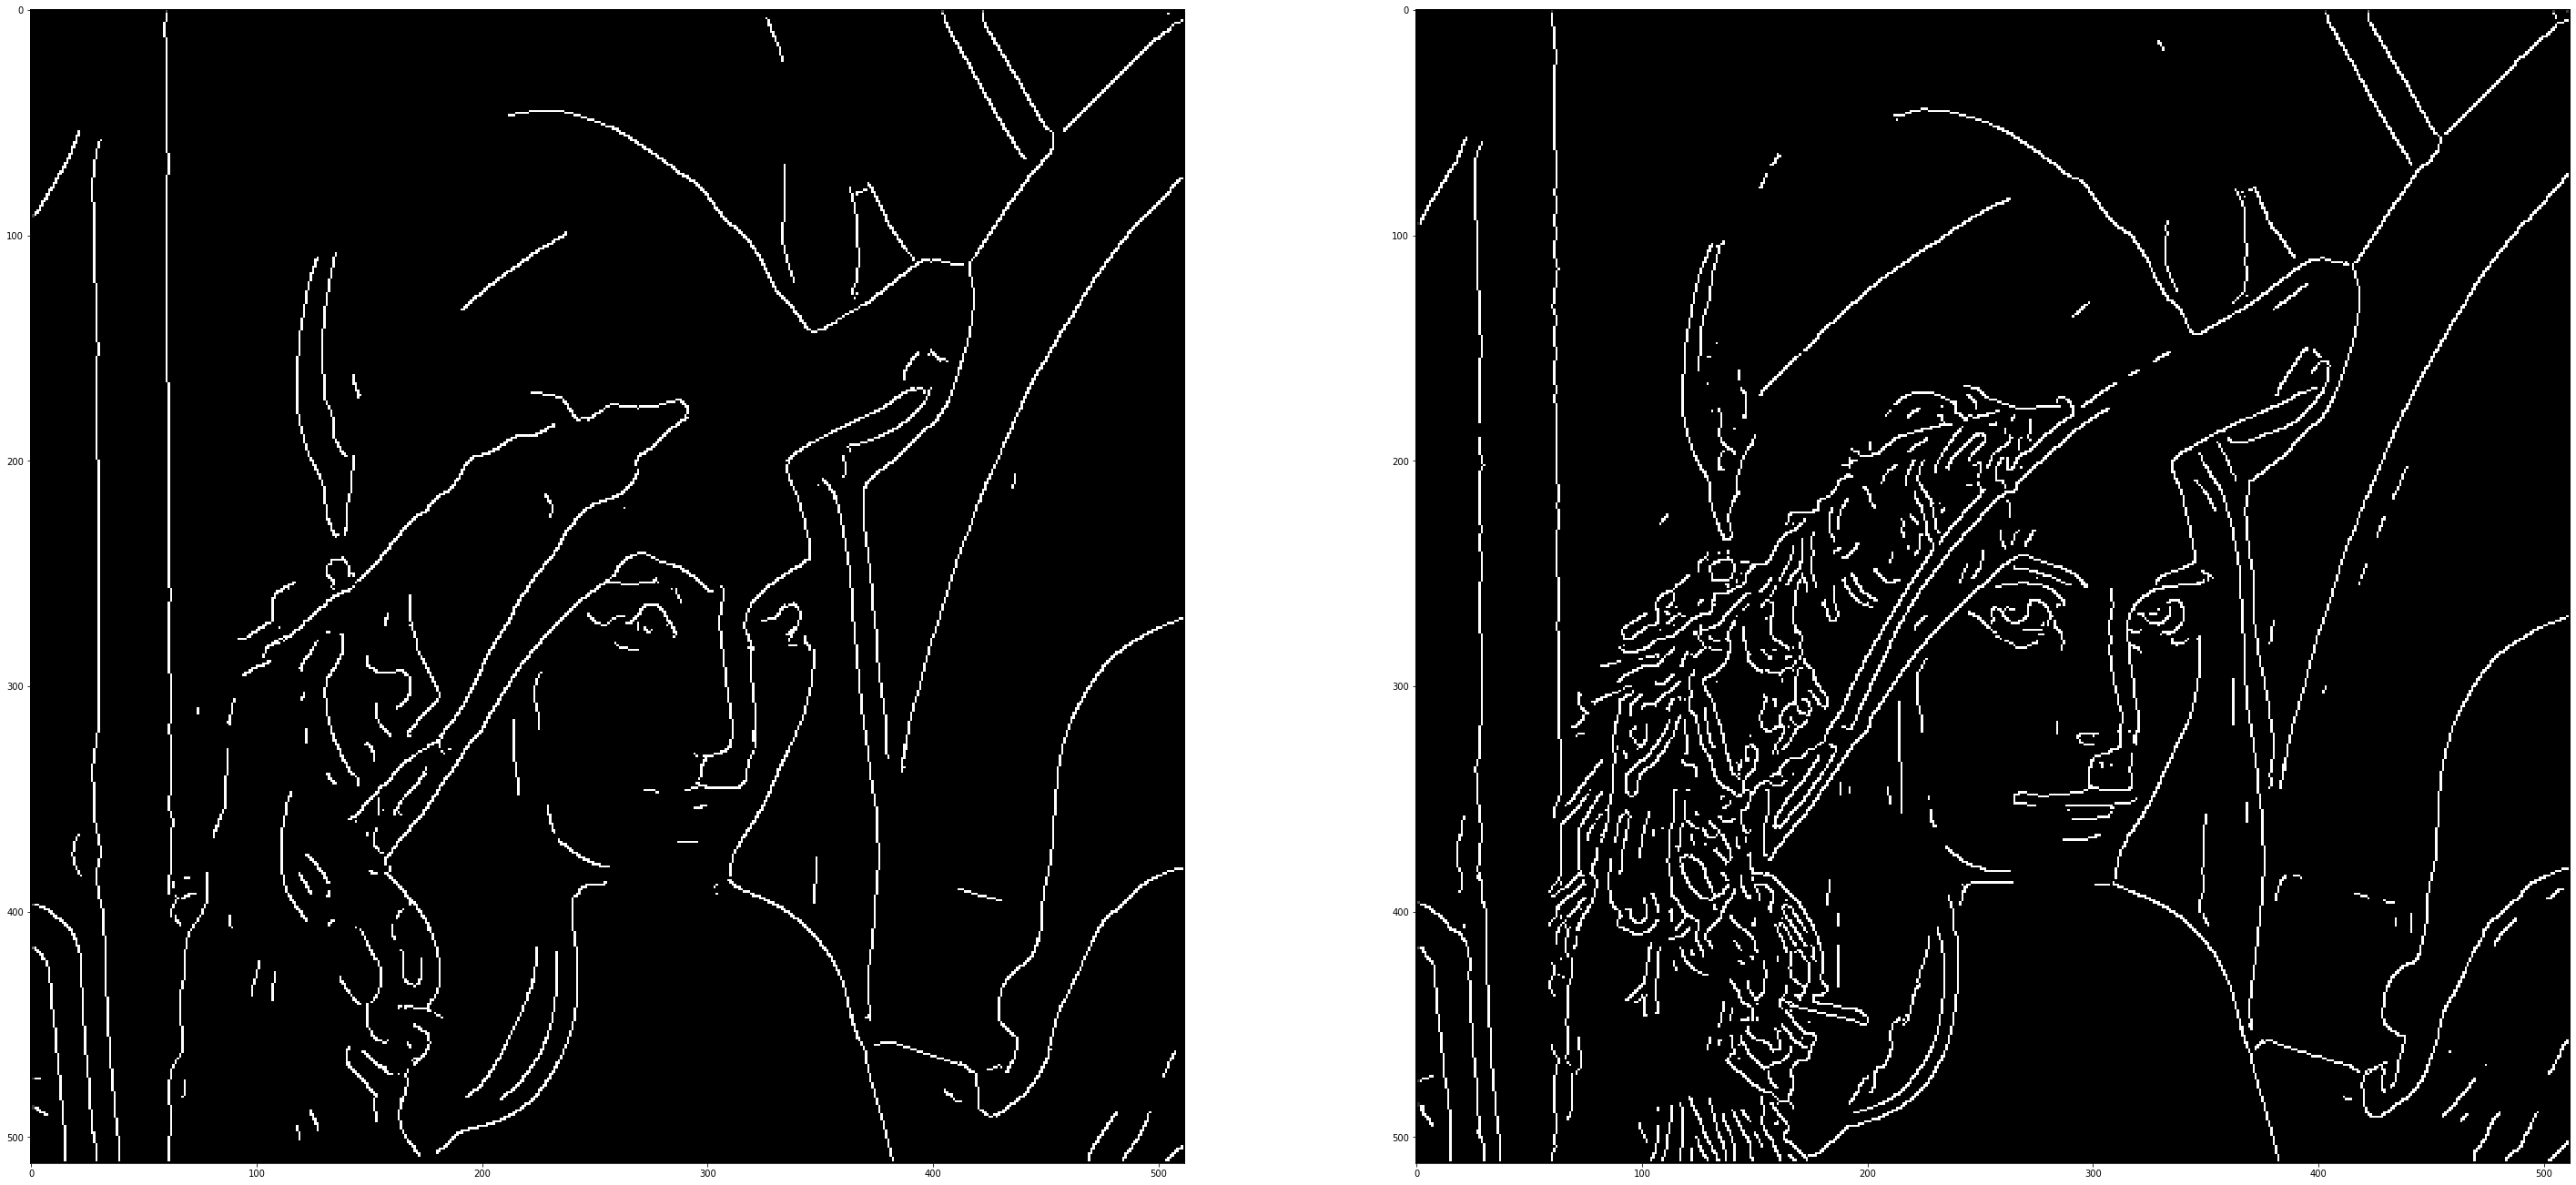

In [56]:
imgs = [canny(4, 0.4, 0.2, lena), canny(2, 0.35, 0.15, lena)]
_, axs = plt.subplots(ncols = len(imgs), figsize = (50, 50))
for index in range(0, len(imgs)):
    axs[index].imshow(imgs[index], cmap = "gray")


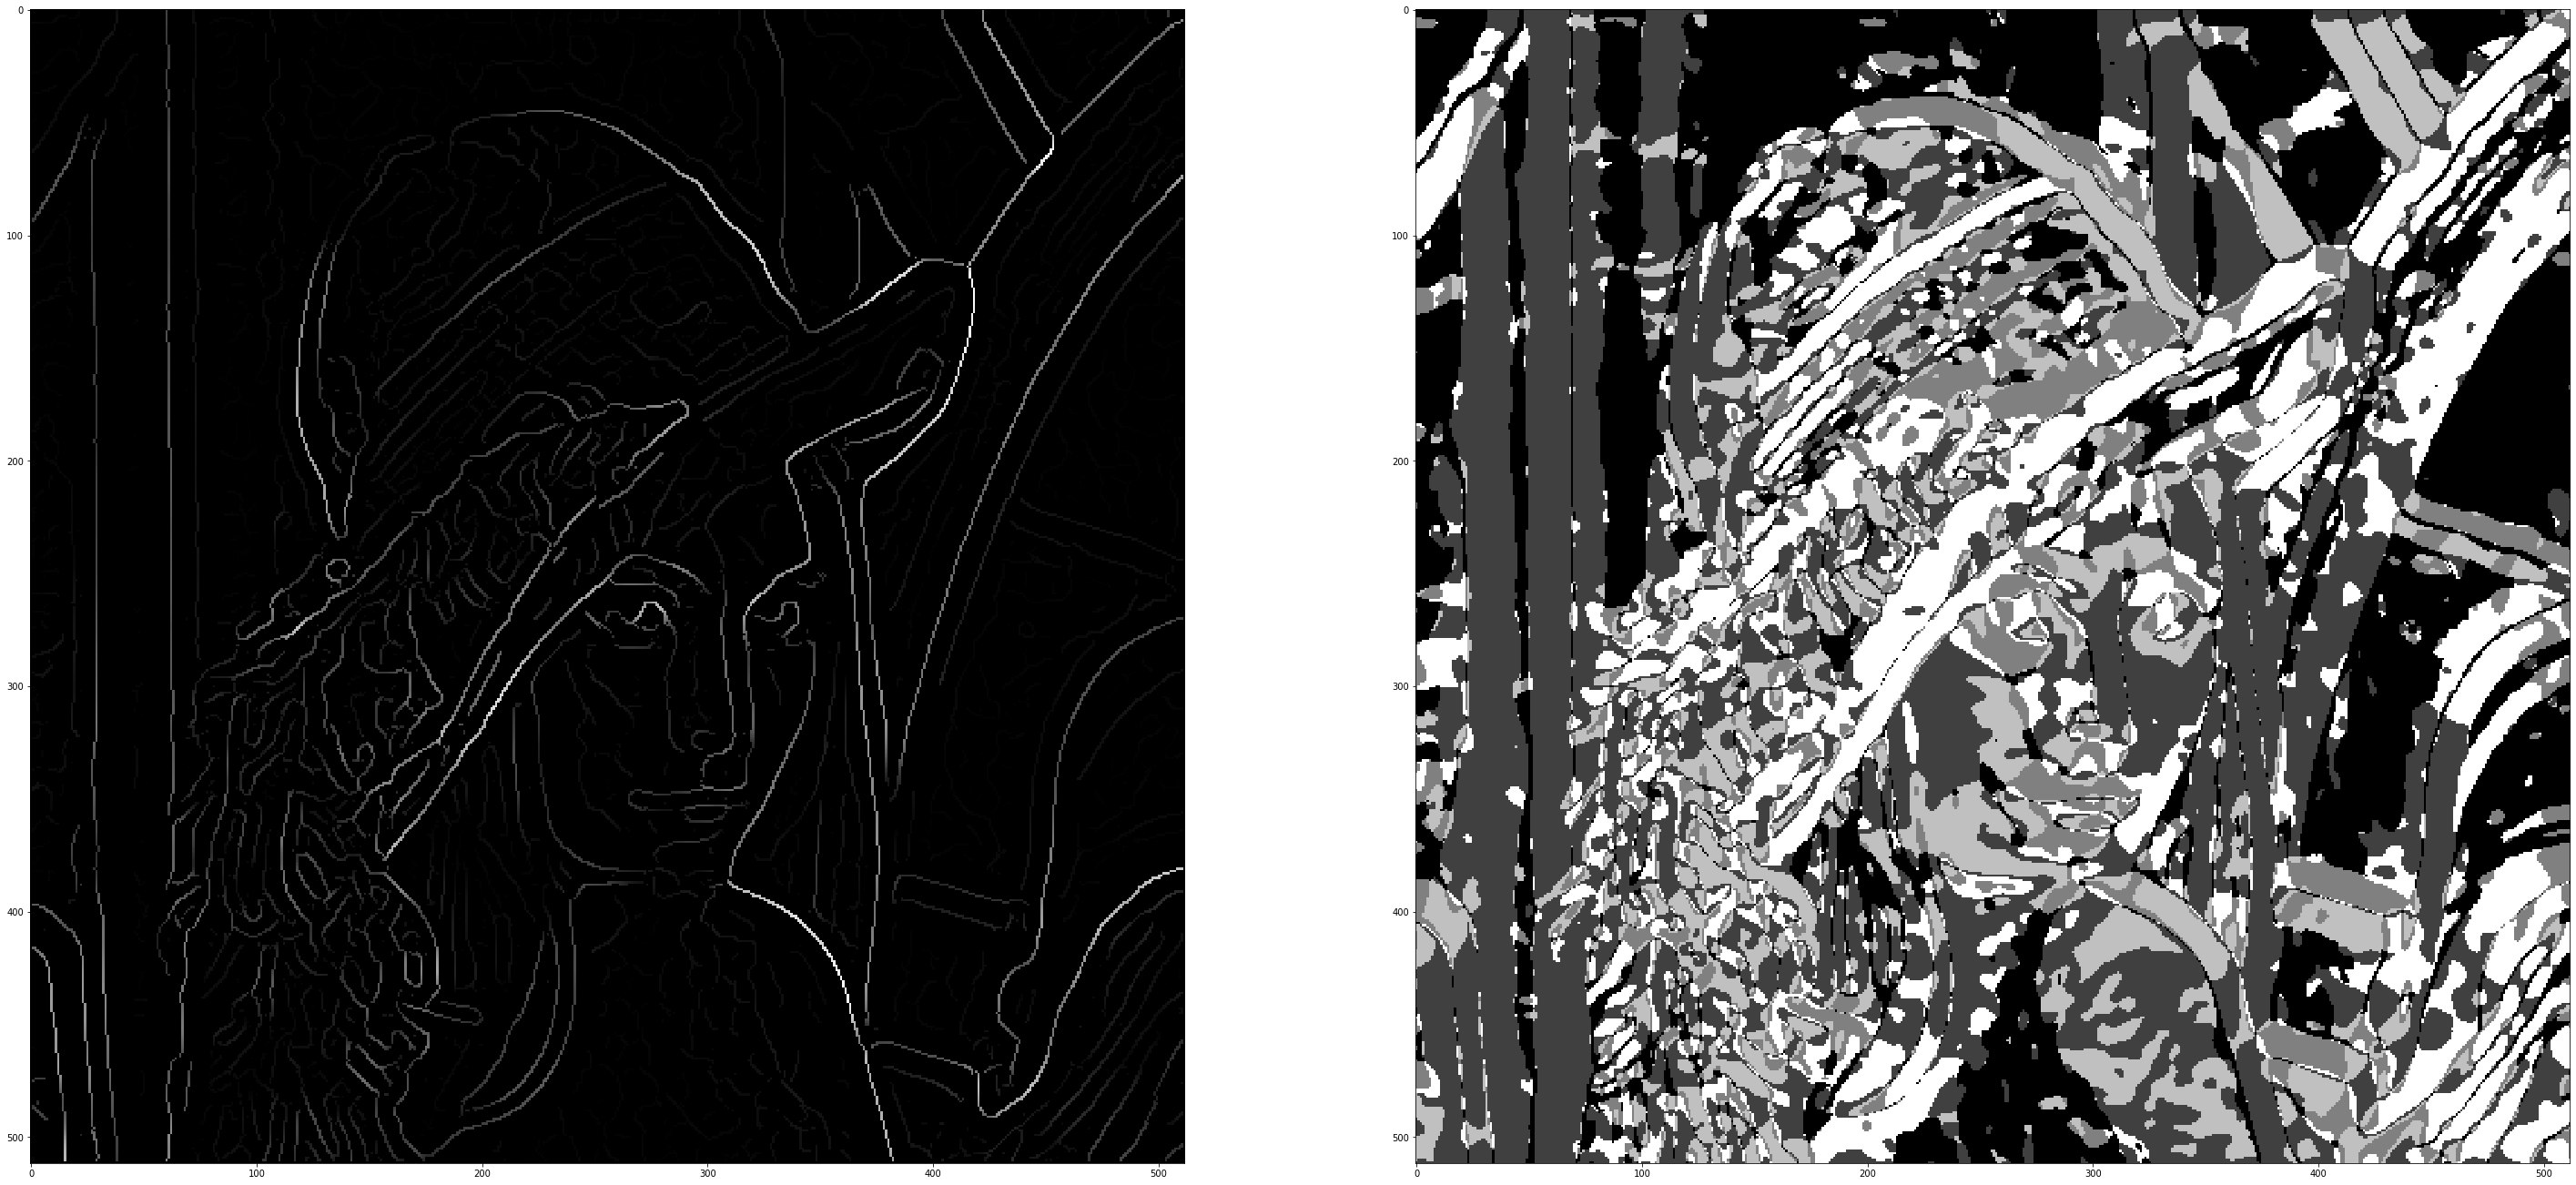

In [60]:
grad_x, grad_y = gradient(3, lena)
magn = np.sqrt(grad_x ** 2 + grad_y ** 2)
grad_x *= 255 / magn.max()
grad_y *= 255 / magn.max()
imgs = [non_max_supressing(3, lena), dir_of_gradient(grad_x, grad_y)]
_, axs = plt.subplots(ncols = len(imgs), figsize = (50, 50))
for index in range(0, len(imgs)):
    axs[index].imshow(imgs[index], cmap = "gray")